## Installations and Packages

In [2]:
!pip install -qU transformers
!pip install nltk
!python -m nltk.downloader punkt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, GPT2LMHeadModel, GPT2Config, AutoConfig, AutoModelWithLMHead, get_linear_schedule_with_warmup
import nltk
from nltk.translate.bleu_score import sentence_bleu
from transformers import AdamW
import random
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re

torch.manual_seed(42)
device = torch.device("cuda")

nltk.download('punkt')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
model_name_or_path = "HooshvareLab/gpt2-fa"

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    bos_token='<s>',
    eos_token='</s>',
    pad_token='<pad>',
    unk_token='<unk>'
)
tokenizer.add_special_tokens({
    "bos_token": '</s>',
    "eos_token": '</s>',
    "pad_token": '<pad>',
    "unk_token": '<unk>'
})

config = AutoConfig.from_pretrained(
    model_name_or_path,
    bos_token_id=tokenizer("<s>")["input_ids"][0],
    eos_token_id=tokenizer("</s>")["input_ids"][0],
    pad_token_id=tokenizer("<pad>")["input_ids"][0],
    unk_token_id=tokenizer("<unk>")["input_ids"][0],
)

tokenizer.save_pretrained("/kaggle/working/gpt2/")
config.save_pretrained("/kaggle/working/gpt2/")

!wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/pytorch_model.bin" -P /kaggle/working/gpt2/
!wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/tokenizer.json" -P /kaggle/working/gpt2/

tokenizer_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/875k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/14.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2024-01-19 16:09:30--  https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/pytorch_model.bin
Resolving huggingface.co (huggingface.co)... 3.163.189.114, 3.163.189.74, 3.163.189.90, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.114|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/HooshvareLab/gpt2-fa/46b0b806c740a0f0a9f056f5574c5fa896166fe844945fd3c849bf34365e5060?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1705939770&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNTkzOTc3MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9Ib29zaHZhcmVMYWIvZ3B0Mi1mYS80NmIwYjgwNmM3NDBhMGYwYTlmMDU2ZjU1NzRjNWZhODk2MTY2ZmU4NDQ5NDVmZDNjODQ5YmYzNDM2NWU1MDYwP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Sig

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2024-01-19 16:09:32--  https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/tokenizer.json
Resolving huggingface.co (huggingface.co)... 3.163.189.74, 3.163.189.37, 3.163.189.114, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748949 (2.6M) [text/plain]
Saving to: '/kaggle/working/gpt2/tokenizer.json.1'

tokenizer.json.1    100%[===================>]   2.62M  --.-KB/s    in 0.1s    

2024-01-19 16:09:33 (26.0 MB/s) - '/kaggle/working/gpt2/tokenizer.json.1' saved [2748949/2748949]



In [5]:
def setseed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

## Dataset

In [6]:
# Read the file
with open("/kaggle/input/dattaa/ferdousi.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()[2:]  # Read from the second line onwards

# Pair odd lines with even lines
paired_lines = []
for i in range(0, len(lines), 2):
    odd_line = lines[i].strip()  # Remove any trailing newline or spaces
    even_line = lines[i + 1].strip() if i + 1 < len(lines) else ''
    paired_line = odd_line + "<sep>" + even_line
    paired_lines.append(paired_line)

# Create a DataFrame from the paired lines
df = pd.DataFrame(paired_lines, columns=["verse"])

# Drop any missing values and reset the index
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

# Convert to a list
texts = df["verse"].values.tolist()

print(len(texts))

49609


In [7]:
# Printing a sample
idx = np.random.randint(0, len(df))
print(idx)
print(df.iloc[idx]["verse"])

3940
بر ویسه شد قارن رزم جوی<sep>ازو ویسه در جنگ برگاشت روی


## Tokenization

In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    "/kaggle/working/gpt2",
    bos_token='<s>',
    eos_token='</s>',
    pad_token='<pad>'
)

# Sample tokenizing
print(tokenizer.encode("به نام خداوند جان و خرد"))
print(tokenizer.encode("<s>"))
print(tokenizer.encode("</s>"))
print(tokenizer.encode("<pad>"))
print(tokenizer.encode("<|startoftext|>"))
print(tokenizer.encode("<sep>"))

[490, 561, 6733, 1305, 293, 2964]
[0]
[2]
[1]
[6]
[9]


In [10]:
max_seq = max([len(tokenizer.encode(text)) for text in texts])

print(f'The longest text is {max_seq} tokens long.')

The longest text is 23 tokens long.


In [11]:
class FerdousiDataset(Dataset):

    def __init__(self, txt_list, tokenizer, max_length=1024):

        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:

            encodings_dict = tokenizer('<s>' + txt + '</s>', truncation=True, max_length=max_length, padding="max_length")

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [12]:
dataset = FerdousiDataset(texts, tokenizer, max_length=max_seq)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'{len(train_dataset)} samples for training, and {len(val_dataset)} samples for validation testing'

'44648 samples for training, and 4961 samples for validation testing'

In [13]:
# Sample train data tokenized and decoded
print(train_dataset[0][0])
print()
print(tokenizer.decode(train_dataset[0][0]))

tensor([    0, 30499, 11798,  7749,  5319,     9,   271, 19993, 14573,   555,
         5240,   330,   900,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1])

<s>ازو پند گیرند ایرانیان<sep>نبندند ازین پس بدی را میان</s><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [14]:
# Train and Test data loaders
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=64
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=64
)

In [15]:
configuration = GPT2Config.from_pretrained('/kaggle/working/gpt2', output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained("/kaggle/working/gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))
model.cuda()

# setup seed
setseed(42)

optimizer = AdamW(model.parameters(), lr=1e-4, eps=1e-8)

epochs = 5
warmup_steps = 1e2
sample_every = 150

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=len(train_dataloader) * epochs)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
sample_input = f"<s>به نام خداوند جان و خرد"
print(sample_input)
sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
sample_input_ids = sample_input_ids.to(device)

sample_outputs = model.generate(
    input_ids=sample_input_ids,
    do_sample=True,
    top_k=50,
    max_length=50,
    top_p=0.95,
    num_return_sequences=1
)
for i, sample_output in enumerate(sample_outputs):
    gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
    gen_sample_output = gen_sample_output.replace("<|startoftext|>", "\n")
    gen_sample_output = gen_sample_output.replace("<s>", "")
    gen_sample_output = gen_sample_output.replace("</s>", "")
    gen_sample_output = gen_sample_output.replace("<sep>", "\n")

    print(f'Example output: {gen_sample_output}')

<s>به نام خداوند جان و خرد
Example output: به نام خداوند جان و خرد است. در این حالت فرد در کنار سایر اعمال خود، بر اراده خود جهت پیروی از دستورات الهی می‌ایستد. یعنی بر خلاف یک فرد در کنار سایر اعمال الهی که بر خلاف دستور و دستورات خداوند جان می


In [17]:
# model structure
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(42001, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=42001, bias=False)
)

In [18]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))


total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch in range(0, epochs):

    print(f'Epoch {epoch + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, labels=b_labels, attention_mask=b_masks, token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)

            # print()
            out = f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}' +'\n'

            model.eval()

            sample_input = f"<s>"
            sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
            sample_input_ids = sample_input_ids.to(device)

            sample_outputs = model.generate(
                input_ids=sample_input_ids,
                # bos_token_id=random.randint(1, len(tokenizer.get_vocab())),
                do_sample=True,
                top_k=50,
                max_length=50,
                top_p=0.95,
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
                gen_sample_output = gen_sample_output.replace("<|startoftext|>", "\n")
                gen_sample_output = gen_sample_output.replace("<s>", "")
                gen_sample_output = gen_sample_output.replace("</s>", "")
                gen_sample_output = gen_sample_output.replace("<sep>", "\n")

                out = out + f'Example output: {gen_sample_output}'

            print(out)

            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print()
    print(f'\n Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    print()

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader, total=len(validation_dataloader), position=0):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs = model(b_input_ids, attention_mask=b_masks, labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    # print()
    tqdm.write(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time} \n')
    # print()

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Epoch 1 of 5


 22%|██▏       | 151/698 [00:31<02:27,  3.72it/s]

Batch 150 of 698. Loss:3.708920478820801. Time:0:00:31
Example output: یکی نامهٔ بزرگان به من بدین گونه داد
برین کس همی مرا بدگمان کرد


 43%|████▎     | 301/698 [01:02<01:48,  3.67it/s]

Batch 300 of 698. Loss:3.444817304611206. Time:0:01:02
Example output: چنین گفت از بهر تو که از منست
خردمند و نیک خواه و نیک خواه


 65%|██████▍   | 451/698 [01:33<01:03,  3.91it/s]

Batch 450 of 698. Loss:3.0716848373413086. Time:0:01:33
Example output: به زودی به نزدیک خسرو برسم
سخنهای او همه دل پاک کنم


 86%|████████▌ | 601/698 [02:04<00:26,  3.71it/s]

Batch 600 of 698. Loss:3.1549062728881836. Time:0:02:04
Example output: بجز کامروز و ز گرد گردان بلند
دلم چو دریای خون و جگر


100%|██████████| 698/698 [02:24<00:00,  4.84it/s]




 Average Training Loss: 3.6633917619300775. Epoch time: 0:02:24



100%|██████████| 78/78 [00:05<00:00, 15.56it/s]


Validation loss: 2.9428084171735325. Validation Time: 0:00:05 

Epoch 2 of 5


 22%|██▏       | 151/698 [00:31<02:26,  3.72it/s]

Batch 150 of 698. Loss:2.8031270503997803. Time:0:00:31
Example output: بدو گفت شاه ای مهربان مرد
تو این نامه را پیش اندر آرند نیز


 43%|████▎     | 301/698 [01:02<01:41,  3.90it/s]

Batch 300 of 698. Loss:2.894868850708008. Time:0:01:02
Example output: همه جنگ لشکر و میدان جنگ
بدیدند ازان کشتگان مرد جنگ


 65%|██████▍   | 451/698 [01:33<01:04,  3.85it/s]

Batch 450 of 698. Loss:2.7897260189056396. Time:0:01:33
Example output: وزان بد دل بود تا توانی مگر
بباید شدن او ازو جای


 86%|████████▌ | 601/698 [02:04<00:25,  3.82it/s]

Batch 600 of 698. Loss:2.6670477390289307. Time:0:02:04
Example output: همه شهر ایران و لشکرش بپای
سکندر نهادند بر جای


100%|██████████| 698/698 [02:23<00:00,  4.85it/s]




 Average Training Loss: 2.7979004362592725. Epoch time: 0:02:24



100%|██████████| 78/78 [00:05<00:00, 15.52it/s]


Validation loss: 2.69329851712936. Validation Time: 0:00:05 

Epoch 3 of 5


 22%|██▏       | 151/698 [00:31<02:26,  3.75it/s]

Batch 150 of 698. Loss:2.6163418292999268. Time:0:00:31
Example output: که امروز این بیژنا بود
به خون دو دیده پر ز خوناب بود


 43%|████▎     | 301/698 [01:02<01:43,  3.83it/s]

Batch 300 of 698. Loss:2.4787681102752686. Time:0:01:02
Example output: وزان پس به نزد او برفتند
برفتند زان انجمن تا سه پاس


 65%|██████▍   | 451/698 [01:33<01:04,  3.80it/s]

Batch 450 of 698. Loss:2.437425136566162. Time:0:01:33
Example output: برفتیم یکسر ز یزدان پناه
که بر چرخ گردان ز مهر


 86%|████████▌ | 601/698 [02:04<00:24,  3.89it/s]

Batch 600 of 698. Loss:2.525743246078491. Time:0:02:04
Example output: چو خسرو به کردار دریای چین
برو گشت زین گونه تا لب جوی


100%|██████████| 698/698 [02:24<00:00,  4.85it/s]




 Average Training Loss: 2.53509547614778. Epoch time: 0:02:24



100%|██████████| 78/78 [00:05<00:00, 15.50it/s]


Validation loss: 2.579962140474564. Validation Time: 0:00:05 

Epoch 4 of 5


 22%|██▏       | 151/698 [00:31<02:25,  3.75it/s]

Batch 150 of 698. Loss:2.4156625270843506. Time:0:00:31
Example output: برفتند پیروز و شادان سپاه
که تا چون بود با من یکی رزمگاه


 43%|████▎     | 301/698 [01:02<01:40,  3.95it/s]

Batch 300 of 698. Loss:2.359818935394287. Time:0:01:02
Example output: به درگاه خاقان نهادند روی
به آیین نیاکان بنشاندند روی


 65%|██████▍   | 451/698 [01:33<01:03,  3.88it/s]

Batch 450 of 698. Loss:2.4241788387298584. Time:0:01:33
Example output: به نزدیک قیصر بیازید راه
به پیش سپاه اندرون دادخواه


 86%|████████▌ | 601/698 [02:04<00:27,  3.56it/s]

Batch 600 of 698. Loss:2.394779920578003. Time:0:02:04
Example output: به دست اندرش گرز و به تیر و کمان
چو تیغ هندی به مشت اندرش جوشن


100%|██████████| 698/698 [02:24<00:00,  4.84it/s]




 Average Training Loss: 2.368366702579837. Epoch time: 0:02:24



100%|██████████| 78/78 [00:05<00:00, 15.52it/s]


Validation loss: 2.5318068113082495. Validation Time: 0:00:05 

Epoch 5 of 5


 22%|██▏       | 151/698 [00:31<02:25,  3.75it/s]

Batch 150 of 698. Loss:2.2523019313812256. Time:0:00:31
Example output: کنون چند بد سگالید شاه
همش بر توان و بر توان کردگاه


 43%|████▎     | 301/698 [01:02<01:47,  3.69it/s]

Batch 300 of 698. Loss:2.2447164058685303. Time:0:01:02
Example output: که آن را به چیزی دگرگونه بد
که او را فگندی به خوبی فراز


 65%|██████▍   | 451/698 [01:33<01:05,  3.75it/s]

Batch 450 of 698. Loss:2.352379083633423. Time:0:01:33
Example output: به هر بد که او مرد پرخاشجوی
بیاراست بر دشت نیزه بپای


 86%|████████▌ | 601/698 [02:04<00:25,  3.88it/s]

Batch 600 of 698. Loss:2.361844778060913. Time:0:02:04
Example output: بدو گفت بیژن که با شهریار
ز لشکر گزین کن یکی نامدار


100%|██████████| 698/698 [02:24<00:00,  4.84it/s]




 Average Training Loss: 2.2642247516309633. Epoch time: 0:02:24



100%|██████████| 78/78 [00:05<00:00, 15.46it/s]

Validation loss: 2.520226701711997. Validation Time: 0:00:05 

Total training took 0:12:25


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

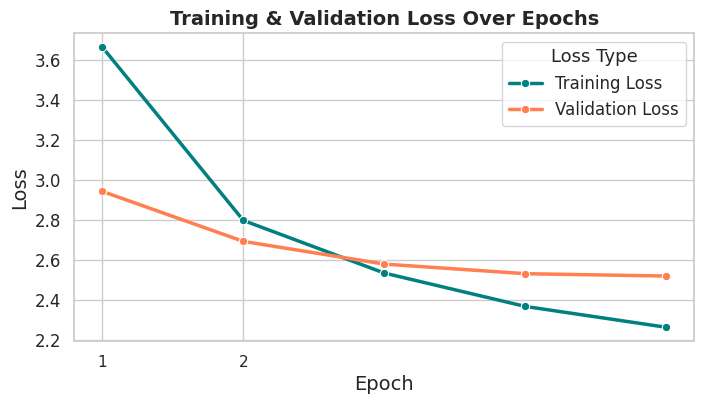

In [19]:
# Set seaborn style
sns.set(style="whitegrid")

# Data Preparation
df_stats = pd.DataFrame(data=training_stats)
df_stats.set_index('epoch', inplace=True)

# Plotting
plt.figure(figsize=(8, 4))

# Plot training and validation loss with new colors and line styles
sns.lineplot(data=df_stats['Training Loss'], marker='o', color='teal', label='Training Loss', linewidth=2.5)
sns.lineplot(data=df_stats['Valid. Loss'], marker='o', color='coral', label='Validation Loss', linewidth=2.5)

# Setting plot title and labels with a new font style
plt.title("Training & Validation Loss Over Epochs", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)

# Customizing the legend
plt.legend(title='Loss Type', title_fontsize='13', fontsize='12')

# Customizing the ticks
plt.xticks(range(1, 3))  # Adjust range according to your number of epochs
plt.yticks(fontsize=12)

# Display the plot
plt.show()

In [20]:
def generator(verse, max_length=128, num_return_sequences=3):
    model.eval()
    prompt = "<s>" + verse

    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    decoded_outputs = model.generate(
        generated,
        do_sample=True,
        top_k=50,
        max_length=max_length,
        top_p=0.95,
        num_return_sequences=num_return_sequences
    )

    outputs = []
    for output in decoded_outputs:
        o = tokenizer.decode(output, skip_special_tokens=False)
        o = o.replace("<s>", "").replace("</s>", "").replace("<pad>", "")
        o = re.sub("\n+", "\n", o.replace("<sep>", "\n")).strip()
        outputs.append(o)

    return outputs

In [21]:
# Example usage
generated_verses = generator("سعدیا مرد نکونام")
for verse in generated_verses:
    print(verse)
    print()

سعدیا مرد نکونام و خسرو نژاد
به نزدیک آن باره شد آن بیدرفشان

سعدیا مرد نکونام بدست
یکی کودکی بی دل و دست و دست

سعدیا مرد نکونام به زیر
برآشفت و شد بی گمان زیر پر



In [22]:
# Example usage
generated_verses = generator("توانا بود")
for verse in generated_verses:
    print(verse)
    print()

توانا بود تا پیش شاه آمدند
بدان جنگ جستن و رای آمدند

توانا بود ما را تو بستی
نباید که بر دیو خویش خواستی

توانا بود تخت عاج و تخت
ببایستت بر سر زینهار بخت



In [23]:
# Example usage
generated_verses = generator("باز باران")
for verse in generated_verses:
    print(verse)
    print()

باز باران بگرفتش بچنگ
چو برگشت از بارهٔ دژ دژ ببست

باز باران نیامد ترا بارمان
همی جست بر گرد دشت کین

باز باران که آید ز جای پدر
وگرنه برآرد ببار از بر سر



In [24]:
def calculate_bleu_score(reference, candidate):

    # Tokenizing the reference and candidate sentences
    reference_tokens = [tokenizer.encode(reference)]
    candidate_tokens = tokenizer.encode(candidate)

    # Calculating BLEU score
    score = sentence_bleu(reference_tokens, candidate_tokens)

    return score

# Example usage
reference = "This is a test sentence."
candidate = "This is a sentence test."
print(calculate_bleu_score(reference, candidate))

0.45966135761245924


In [25]:
def generator(generated, max_length=128, num_return_sequences=3):

    model.eval()
    generated = torch.tensor(tokenizer.encode(generated)).unsqueeze(0)
    generated = generated.to(device)

    decoded_outputs = model.generate(
        generated,
        do_sample=True,
        top_k=50,
        max_length=max_length,
        top_p=0.95,
        num_return_sequences=num_return_sequences
    )

    outputs = []
    for output in decoded_outputs:
        o = tokenizer.decode(output, skip_special_tokens=False)
        outputs.append(o)

    return outputs

model.eval()

# Iterate over validation data
num_samples = 0
total_bleu_score = 0

for idx, (source, target) in enumerate(val_dataset):
    couplet = tokenizer.decode(source, skip_special_tokens=False).replace("<pad>", "")
    verse = couplet.split("<sep>", 1)[0]  # First verse

    generated_translations = generator(verse)
    best_translation = generated_translations[0].replace("<pad>", "")

    bleu_score = calculate_bleu_score(couplet, best_translation)
    total_bleu_score += bleu_score
    num_samples += 1

    # Print every 500 samples
    if idx % 500 == 0:
        print(f"Sample {idx}:")
        # print("Verse:", verse)
        print("Best Translation:", best_translation)
        print("Couplet:", couplet)
        print("Bleu Score:", bleu_score)
        print("\n")

# Calculate the average BLEU score
average_bleu_score = total_bleu_score / num_samples if num_samples else 0
print(f"Average BLEU Score on Validation Set: {average_bleu_score:.2f}")

Sample 0:
Best Translation: <s>سواران گردنکش از کشورش<sep>گشاده بود و گر تنگ بسته کشورش</s>
Couplet: <s>سواران گردنکش از کشورش<sep>همه راه را ساخته بر درش</s>
Bleu Score: 0.3850322886878713


Sample 500:
Best Translation: <s>چو از خوان برفت آب بگساردم<sep>دگر پیش او رفت اندر ستم</s>
Couplet: <s>چو از خوان برفت آب بگساردم<sep>زمین ز آبدستان مگر یافت نم</s>
Bleu Score: 0.5767908748024404


Sample 1000:
Best Translation: <s>مبادت فراموش گفتار من<sep>که چون او نبینی ز گفتار من</s>
Couplet: <s>مبادت فراموش گفتار من<sep>اگر دور مانی ز دیدار من</s>
Bleu Score: 0.42311785416105785


Sample 1500:
Best Translation: <s>چو نزدیک کوه هماون رسید<sep>پس پشت جنگیان سپاه دید</s>
Couplet: <s>چو نزدیک کوه هماون رسید<sep>بران دامن کوه لشکر کشید</s>
Bleu Score: 0.49009410393069486


Sample 2000:
Best Translation: <s>بسی نامدار از پی نام و ننگ<sep>که پیش آورد لشکر به جنگ</s>
Couplet: <s>بسی نامدار از پی نام و ننگ<sep>بدادند بر خیره سرها بجنگ</s>
Bleu Score: 0.4947328597494975


Sample 2500:
Best Translation

### Inspired by the refrence on fine tuning the GPT2-fa model